## PDECO Method for KS Inversion
Please check the original paper of the PDE-Constrained Optimization method:
 <br>[Jensen Wasserman, Int J Quantum Chem. 2018;118:e25425](https://onlinelibrary.wiley.com/doi/full/10.1002/qua.25425);
 <br>[Kanungo, Zimmerman, Gavini, Nat Commun 10, 4497 (2019)](https://doi.org/10.1038)

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 


  Memory set to   2.328 GiB by Python driver.


---
### Perform target calculation with Psi4. 
Store wavefunction (wfn) object

In [2]:
Ne = psi4.geometry( 
""" 
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole moments instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter.from_wfn(wfn, pbs="aug-cc-pvqz")

PDECO is based on a very simple intuition: the better the density, the better the XC potential will be, at least in the region close enough to the exact density and exact XC potential. Based on this, a density error is defined and optimized:
$$N_{error} = \int dr|n(r) - n_{in}(r)|^2.$$
In order to optimize this, a Lagrangian is defined:
\begin{split}
&L\left[v_{KS}, \{\psi_i\}, \{\epsilon_i\}, \{p_i\}, \{\mu_i\}\right]\\
    =& \int(n(r)-n_{in}(r))^2 dr \\ 
    & + \sum_{i=1}^{N/2}\int p_i(r)(-\frac{1}{2}\nabla^2+v_{KS}(r) - \epsilon_i)\psi_i(r)dr\\
    &+\sum_{i=1}^{N/2}\mu_i(\int|\psi_i(r)|^2dr-1)
\end{split}
where where $\{p_i\}$ and $\{\mu_i\}$ are Lagrange multipliers for the constraints that $\{\psi_i\}$ are the KS orbitals of $v_{KS}$ with corresponding eigenvalue $\{\epsilon_i\}$ and that the $\{\psi_i\}$ are normalized.

The gradient of this Lagrangian with respect to $v_{XC}$ can be derived by solving the following equations in sequence:
$
\begin{align}
&(-\frac{1}{2}\nabla^2+v_{KS}(r))\psi_i(r) = \epsilon_i\psi_i(r),\\ %\label{equ:CONormalEquationa}\\
&\int |\psi_i(r)|^2 dr= 1,\\
&(-\frac{1}{2}\nabla^2+v_{KS}(r) - \epsilon_i)p_i(r)= 8(n\in(r)-n(r))\psi_i(r) - 2\mu_i\psi_i(r),\\
&\int p_i(r)\psi_i(r)dr = 0,\\
&\frac{\delta L}{\delta v_{KS}(r)}=\sum_{i=1}^{N/2}p_i(r)\psi_i(r).
\end{align}
$
It should be noted that, clearly $p_i$ is orthogonal to $\psi_i$ and that $(-\frac{1}{2}\nabla^2+v_{KS}(r) - \epsilon_i)$ is singular. The current implementation of n2v can produce problems here for some systems because of the linear solver used as well as the finite basis set for representing $\{p_i\}.$

---
### Invert! 
$$v_{Kohn-Sham}=v_{ext}+v_{guide}+v_{rest}$$
With the guide potential $v_{guide}=v_{Fermi-Amaldi}$ and the rest potential $v_{rest}$ on the potential basis set (pbs) "aug-cc-pvqz".

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("PDECO", opt_max_iter=200, guide_components="fermi_amaldi", gtol=1e-6)

4-AO-Overlap tensor will take about 0.000560 GB.
Optimization Successful within 129 iterations! |grad|=7.93e-05.


---

### Visualization of the potentials. 
#### Since this is a 1-D system, let's first plot it alone x axis.

In [4]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grids = np.array([x,y,z])
grids.shape

# Alterantively, we can use the generate grid function. 
grids_temp, _ = ine.eng.grid.generate_grid(x=x, y=[0], z=[0])

Get exchange-correlation potentials.
\begin{align}
v_{xc}
&=v_{Kohn-Sham}-v_{Hartree}-v_{ext}\\
&=v_{guide}+v_{rest}-v_{Hartree}
\end{align}

In [5]:
vrest = ine.eng.grid.ao(ine.v_pbs, grid=grids, basis=ine.eng.pbs)  # Note that specify the basis set that vrest is on.

In [6]:
# Get Hartree and Fermi-Amaldi potentials

vH = ine.eng.grid.esp(Da=ine.Dt[0], Db=ine.Dt[1], grid=grids)[1]
vFA = (1-1/(ine.nalpha + ine.nbeta)) * vH

# Build Vxc
vxc = vFA + vrest - vH

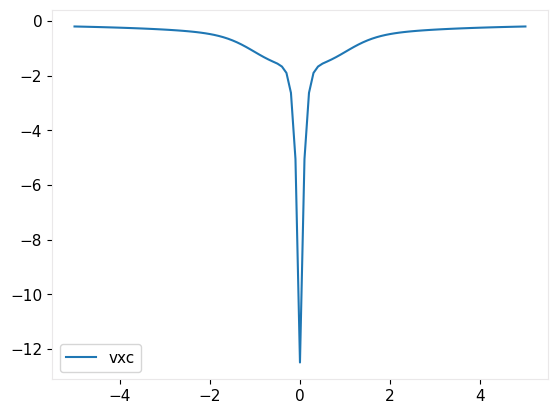

In [7]:
fig, ax = plt.subplots()
ax.plot(x, vxc, label='vxc')
ax.legend()

---
# Unrestricted Calculation 

In [8]:
psi4.set_options({"reference" : "uhf"})  # Spin-Restricted

# IMPORTANT NOTE: psi4.energy does not update cc densities. So we calculate dipole moments instead.
wfn = psi4.properties("ccsd/aug-cc-pvtz",  return_wfn=True, molecule=Ne, property=['dipole'])[1]

# Build inverter and set target
ine = n2v.Inverter.from_wfn(wfn, pbs="aug-cc-pvqz")

In [9]:
wfn.to_file()['boolean']['same_a_b_dens']


False

In [10]:
psi4.core.get_global_option('reference')

'UHF'

In [11]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
ine.v_pbs = np.zeros_like(ine.v_pbs)
ine.invert("PDECO", opt_max_iter=200, guide_components="fermi_amaldi", gtol=1e-6)

4-AO-Overlap tensor will take about 0.000560 GB.
Optimization Successful within 16 iterations! |grad|=2.15e-05.


In [12]:
x = np.linspace(-5,5,101)
y = np.zeros_like(x)
z = np.zeros_like(x)
grid = np.array([x,y,z])

vH = ine.eng.grid.esp(Da=ine.Dt[0], Db=ine.Dt[1], grid=grid)[1]
vFA = (1-1/(ine.nalpha + ine.nbeta)) * vH

In [13]:
vrest_a = ine.eng.grid.ao(ine.v_pbs[:ine.npbs], grid=grid, basis=ine.eng.pbs)  # Note that specify the basis set 
                                                               # that vrest is on.
vxc_a = vFA + vrest_a - vH

In [14]:
vrest_b = ine.eng.grid.ao(ine.v_pbs[ine.npbs:], grid=grids, basis=ine.eng.pbs)  # Note that specify the basis set 
                                                               # that vrest is on.
vxc_b = vFA + vrest_b - vH

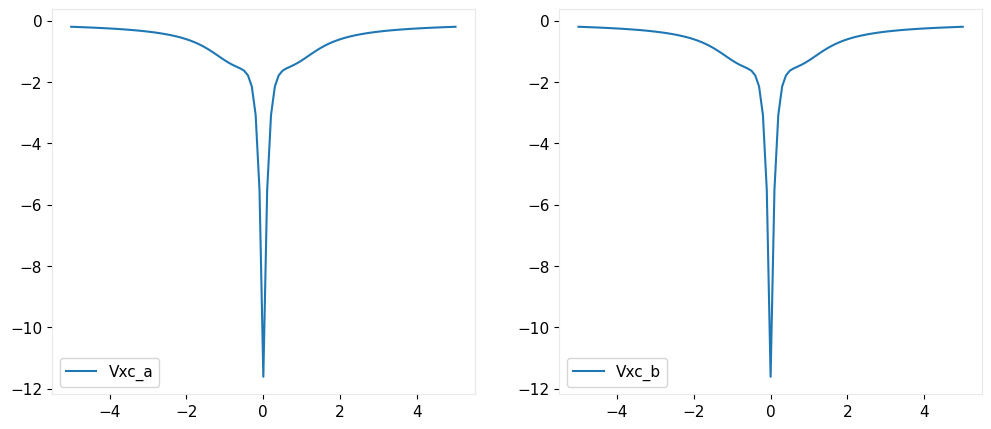

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, vxc_a, label='Vxc_a')
ax[1].plot(x, vxc_b, label='Vxc_b')
ax[0].legend()
ax[1].legend()

In [16]:
ine.ref

2